**Curve Fitting**

It can be usefull to go from one soil model to the other. When the soil parameters are known the soil water retention curve and hydraulic conductivity function can be fitted.

In [1]:
import pedon as pe
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_compare(soilsample: pe.SoilSample, soilmodel: pe.soilmodel.SoilModel):
    f, ax = plt.subplots(1, 2, sharey=True, figsize=(4.2, 4.5))
    ax[0].scatter(soilsample.theta, soilsample.h, c="k", s=10, label="Soil Sample")
    _ = pe.soilmodel.plot_swrc(
        soilmodel, ax=ax[0], label=f"Fitted Soil Model {soilmodel.__class__.__name__}"
    )
    ax[0].set_yscale("log")
    ax[0].set_xlim(0, 0.5)
    ax[0].set_yticks(soilsample.h)
    ax[0].set_xticks(np.linspace(0, 0.5, 6))

    ax[1].scatter(soilsample.k, soilsample.h, c="k", s=10)
    _ = pe.soilmodel.plot_hcf(soilmodel, ax=ax[1])

    ax[1].set_yscale("log")
    ax[1].set_xscale("log")

    k_left = 10 ** (np.floor(np.log10(min(soilsample.k))) - 1)
    k_right = 10 ** (np.ceil(np.log10(max(soilsample.k))) + 1)
    ax[1].set_xlim(k_left, k_right)
    ax[0].set_ylabel(r"|$\psi$| [cm]")
    ax[0].set_xlabel(r"$\theta$ [-]")
    ax[1].set_xlabel(r"$K_s$ [cm/d]")
    ncol = 3
    ax[0].legend(
        loc=(-0.02, 1),
        fontsize=6,
        frameon=False,
        ncol=ncol,
        columnspacing=0.8,
        handlelength=2.5,
    )

    f.align_xlabels()
    # plt.close(f)

In [3]:
sn = "Sand"
soil = pe.Soil(sn).from_name(pe.Genuchten, "HYDRUS")
soilm_genuchten = getattr(soil, "model")
soilm_genuchten

Genuchten(k_s=712.8, theta_r=0.045, theta_s=0.43, alpha=0.145, n=2.68, l=0.5)

In [4]:
h = np.logspace(-4, 6, num=11)
k = soilm_genuchten.k(h)
theta = soilm_genuchten.theta(h)

In [5]:
soilsample = pe.SoilSample(h=h, k=k, theta=theta)
soilsample

SoilSample(sand_p=None, silt_p=None, clay_p=None, rho=None, th33=None, th1500=None, om_p=None, m50=None)

In [6]:
soilm_panday = soilsample.fit(
    pe.Panday,
)
soilm_panday

Panday(k_s=579.2644356372081, alpha=0.1472262954630398, beta=2.629461599428002, brook=3.850325533054728, sr=0.10441881484323215)

The fit method finds the optimal curve through both the soil water retention curve and hydraulic conductivity function at the same time using the least squares algorithm. All parameters are subject to the optimization algorithm.

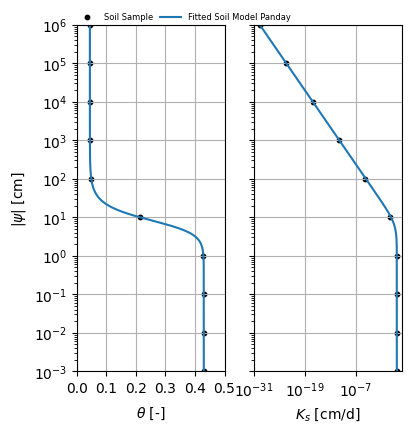

In [7]:
plot_compare(soilsample, soilm_panday)

It can be favorable to only optimize the relative hydraulic conductivity function, and leave parameter k_s untouched. That kan be achieved by providing `k_s` to the fit method.

In [8]:
soilm_panday = soilsample.fit(pe.Panday, k_s=max(soilsample.k))
soilm_panday

Panday(k_s=712.7999894094452, alpha=0.14790376878960756, beta=2.614921028771825, brook=3.89780784854566, sr=0.10434739833114794)

It is also possible to provide bounds for the parameter space. By default, the bounds argument is `None` which takes the stored parameter bounds per soil model:

In [9]:
panday_bounds = pe._params.pPanday.copy()
panday_bounds

,p_ini,p_min,p_max,swrc
k_s,50.00,0.00100,100000.0,False
theta_r,0.02,0.00001,0.2,True
theta_s,0.40,0.20000,0.5,True
alpha,0.02,0.00100,0.3,True
beta,2.30,1.00000,12.0,True
brook,10.00,1.00000,50.0,False


In [10]:
panday_bounds.loc["k_s", "p_min"] = 650
panday_bounds.loc["k_s", "p_ini"] = max(soilsample.k)
soilm_panday = soilsample.fit(pe.Panday, pbounds=panday_bounds)
soilm_panday

Panday(k_s=650.0023315503577, alpha=0.14760418018418328, beta=2.6213048302921647, brook=3.876780843640316, sr=0.10437900805049694)

Other available option are to print the optimization result.

In [11]:
soilm_panday = soilsample.fit(pe.Panday, silent=False)

SciPy Optimization Result
      message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 4.247e-05  4.247e-05 ...  1.242e-04  3.563e-04]
           x: [ 5.793e+02  4.490e-02  4.300e-01  1.472e-01  2.629e+00
                3.850e+00]
        cost: 1.0689285556262866e-06
         jac: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
               ...
               [-2.762e-06  0.000e+00 ...  5.912e-02  2.502e-02]
               [-2.762e-06  0.000e+00 ...  7.331e-02  3.102e-02]]
        grad: [ 3.400e-15 -7.665e-10  1.232e-09 -7.671e-09 -1.022e-09
               -1.313e-10]
  optimality: 9.57854018873565e-09
 active_mask: [0 0 0 0 0 0]
        nfev: 11
        njev: 11


Other parameters are W1 and W2 that determine the weight of the hydraulic conductivity function (with respect to the SWRC). Default value for W1 is 0.1 which implies that the weight of the HCF is 10% than that of the SWRC. W2 ensures that proportional weight is given to the two types of data: `theta` and `k`. `k` is log optimized. Also weights can be added as an array to weigh each individual measurement. 

In [15]:
weights = np.ones(theta.shape)
M = len(k) + len(theta)
N = len(theta)
W2 = (M - N) * sum(weights * theta) / (N * sum(weights * np.abs(np.log(k))))
W2

0.011126595857906313